# Imports

In [49]:
import pandas as pd
import os
import pylab as plt
import numpy as np

import seaborn as sns

import gitsu_analytics as ga

%matplotlib inline
plt.style.use(ga.settings.STYLESHEET_FILEPATH)


In [50]:
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 20

In [51]:
class Crayons:
    dark_grey = '#5E5E5E'
    grey = '#919191'
    light_grey = '#C0C0C0'    
    dark_red = '#941100'
    dark_blue = '#005493'
    yellow = '#FEC139'
    green = '#009051'
    
crayons = Crayons() 
crayons.__dict__.update({k.replace(' ', '_').lower(): v for k, v in sns.colors.crayons.items()})

# Globals

# Data

## df_issues

In [52]:
query = """
SELECT 
  iss.*
  , creator.user_name AS issue_user_name
FROM 
    github_issue iss
    LEFT JOIN github_user creator ON 
        creator.user_ext_id = iss.issue_user_ext_id

WHERE
    NOT iss.issue_is_pull_request
    --AND iss.issue_repo_id = 'gutenburg' -- TODO: need to fix this....

"""
df_issues = ga.db_execute(query)

2019-04-22T06:18:49 27 database  :L168 INFO     | query returned 7917 rows in 0:00:00.389247


In [53]:
df_issues['issue_created_at_date'] = df_issues['issue_created_at'].dt.date
df_issues['issue_closed_at_date'] = df_issues['issue_closed_at'].dt.date
df_issues['issue_updated_at_date'] = df_issues['issue_updated_at'].dt.date

## df_events

In [54]:
query = """
SELECT 
    e.* 
    , u.user_name AS event_actor_username
FROM
    github_issue_event e
    JOIN github_issue iss ON iss.issue_ext_id = e.event_issue_ext_id
    LEFT JOIN github_user u ON u.user_ext_id = e.event_user_ext_id
WHERE
    NOT iss.issue_is_pull_request
"""
df_events = ga.db_execute(query)

2019-04-22T06:18:50 27 database  :L168 INFO     | query returned 60744 rows in 0:00:01.380596


In [55]:
df_events['event_created_at_date'] = df_events['event_created_at'].dt.date 

In [56]:
# df = ga.db_execute("""
# select * from data_lake
# WHERE
#     schema='github_issue_event'
# LIMIT 10

# """)

In [57]:
df_events.groupby('event').size().sort_values()

event
unlocked                   2
locked                     7
unpinned                   8
pinned                     9
unsubscribed              14
marked_as_duplicate       29
comment_deleted           32
unassigned               224
reopened                 299
renamed                 1292
assigned                1617
demilestoned            1689
referenced              1753
unlabeled               2422
milestoned              3148
closed                  6706
mentioned              11956
subscribed             12278
labeled                17259
dtype: int64

## df_actor_issues_closed

In [58]:
df_actor_issues_closed = (
    df_events
    .query('event == "closed"')    
    .groupby([
        'event_created_at_date',
        'event_actor_username',
    ])
    ['event_issue_ext_id']
    .nunique()
    .unstack()
    
)

## df_day_issues

In [59]:
def calc_day_issues(df_issues):
    #################################################
    gb = (
        df_issues
        .groupby([
            'issue_created_at_date',
        ])
    )
    df = pd.DataFrame()
    df['issues_created_cnt'] = gb.size()
    df_day_created = df    
    
    #################################################
    gb = (
        df_issues
        .groupby([
            'issue_closed_at_date',
        ])
    )
    df = pd.DataFrame()
    df['issues_closed_cnt'] = gb.size()
    df_day_closed = df    
    
    #################################################
    gb = (
        df_issues
        .groupby([
            'issue_updated_at_date',
        ])
    )
    df = pd.DataFrame()
    df['issues_updated_cnt'] = gb.size()
    df_day_updated = df  
    
    #################################################
    df = (
        df_day_created
        .merge(
            df_day_closed,
            how='outer',
            left_index=True,
            right_index=True,
        )
        .merge(
            df_day_updated,
            how='outer',
            left_index=True,
            right_index=True,
        )  
        .sort_index()
    )
    idx = pd.date_range(
        df.index.min(),
        df.index.max(),
    )

    df_day_issues = (
        df
        .reindex(idx)
        .fillna(0)
    )  
    return df_day_issues

In [60]:
df_day_issues = calc_day_issues(df_issues)

In [61]:
df_day_issues['issues_created_cnt_cuml'] = df_day_issues['issues_created_cnt'].cumsum()
df_day_issues['issues_closed_cnt_cuml'] = df_day_issues['issues_closed_cnt'].cumsum()
df_day_issues['issues_open'] = df_day_issues['issues_created_cnt_cuml'] - df_day_issues['issues_closed_cnt_cuml']

df_day_issues['issues_unupdated'] = df_day_issues['issues_created_cnt_cuml'] - df_day_issues['issues_updated_cnt'].cumsum()


In [62]:
df_day_issues['issues_labeled_by_designsimply'] = (
    df_events
    .query('event_actor_username == "designsimply"')
    .query('event == "labeled"')
    .groupby('event_created_at_date')
    ['event_issue_ext_id']
    .nunique()
)

In [63]:
df_day_issues['issues_effected_by_designsimply'] = (
    df_events
    .query('event_actor_username == "designsimply"')
    .groupby('event_created_at_date')
    ['event_issue_ext_id']
    .nunique()
)

In [64]:
df_day_issues['events_by_designsimply'] = (
    df_events
    .query('event_actor_username == "designsimply"')
    .groupby('event_created_at_date')
    .size()
)

In [65]:
df_day_issues['issues_closed_by_designsimply'] = (
    df_events
    .query('event_actor_username == "designsimply"')
    .query('event == "closed"')
    .groupby('event_created_at_date')
    .size()
)

# Analyze

In [66]:
DESIGNSIMPLY_START_DATE = pd.Timestamp('2018-06-25').date()
DESIGNSIMPLY_END_DATE = pd.Timestamp('2019-01-11').date()

def plot_designsimply_start_date(**kws):
    defaults = dict(
         alpha=0.8,    
        color='#68D7EE',
        ls='--',
        label='designsimply {}'.format(DESIGNSIMPLY_START_DATE.isoformat()),
    )
    defaults.update(kws)
    plt.axvline(DESIGNSIMPLY_START_DATE, **defaults)

    
    defaults = dict(
        alpha=0.8,    
        color='#68D7EE',
        ls='--',
        label='designsimply {}'.format(DESIGNSIMPLY_END_DATE.isoformat()),
    )
    defaults.update(kws)
    plt.axvline(DESIGNSIMPLY_END_DATE, **defaults)
    
    

In [67]:
def plot_attrs_time():
    plt.gca().xaxis.set_major_locator(
        plt.matplotlib.dates.MonthLocator(range(1, 13), bymonthday=1, interval=1)
    )
    plt.gca().xaxis.set_major_formatter(
        plt.matplotlib.dates.DateFormatter('%b %Y')
    )
    plt.xlabel('')
    plt.xticks(rotation=35, ha='right')
    

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


## Events Loaded

In [68]:
number_of_unloaded_events = df_issues['issue_events_last_loaded_at'].isnull().sum()
print('{} issues without loaded events'.format(number_of_unloaded_events))

0 issues without loaded events


## Issues Created/Closed

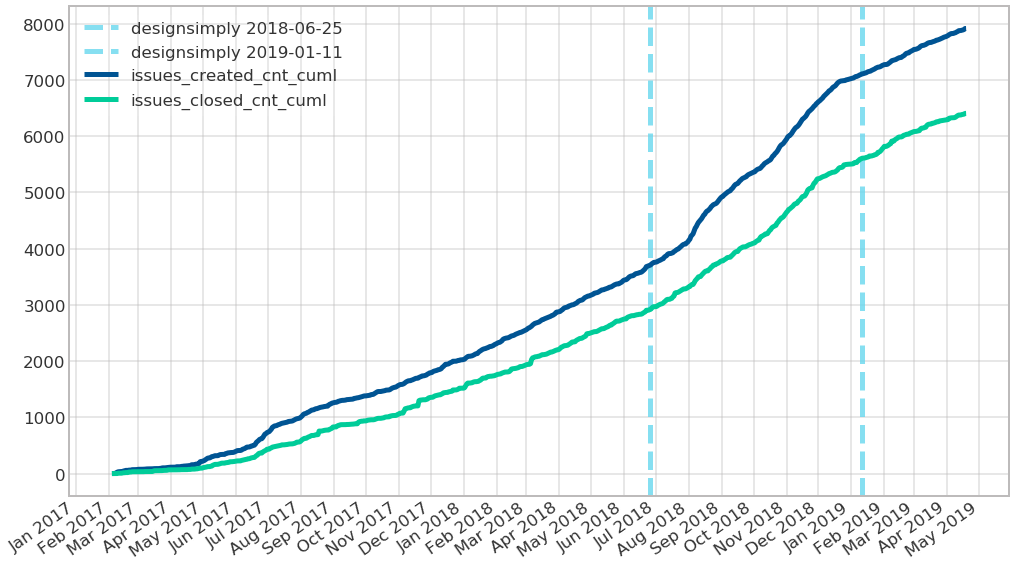

In [69]:
plt.figure(figsize=(15, 10))

plot_designsimply_start_date()

df_day_issues['issues_created_cnt_cuml'].plot(
    color=crayons.dark_blue,
)
df_day_issues['issues_closed_cnt_cuml'].plot(
    color=crayons.caribbean_green,

)
# df_day_issues['issues_updated_cnt'].cumsum().plot(
#     color=crayons.yellow,
#     alpha=0.4,

# )
plt.legend()
plot_attrs_time()

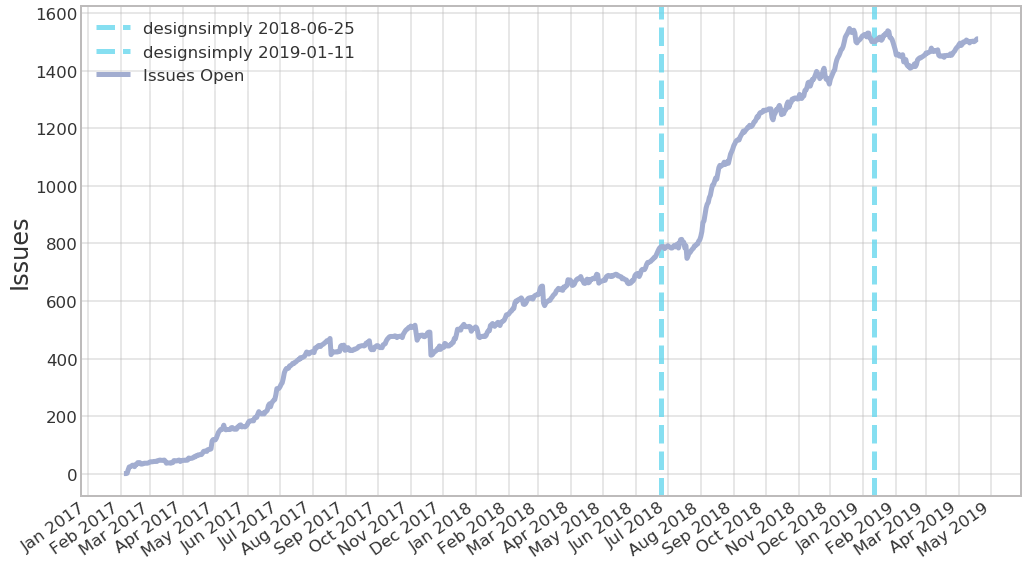

In [70]:
plt.figure(figsize=(15, 10))

plot_designsimply_start_date()
df_day_issues['issues_open'].plot(
    label='Issues Open',
    color=crayons.wild_blue_yonder,
)

# df_day_issues['issues_unupdated'].plot(
#     label='Un-updated Issues',
#     color=crayons.yellow,
#     alpha=0.8,
# )

# df_day_issues['issues_closed_by_designsimply'].fillna(0).cumsum().plot(
#     label='Issues closed by designsimply',
# )


plt.legend(loc=2)
plt.ylabel('Issues')
plot_attrs_time()

## Issues Created/Closed Per Day

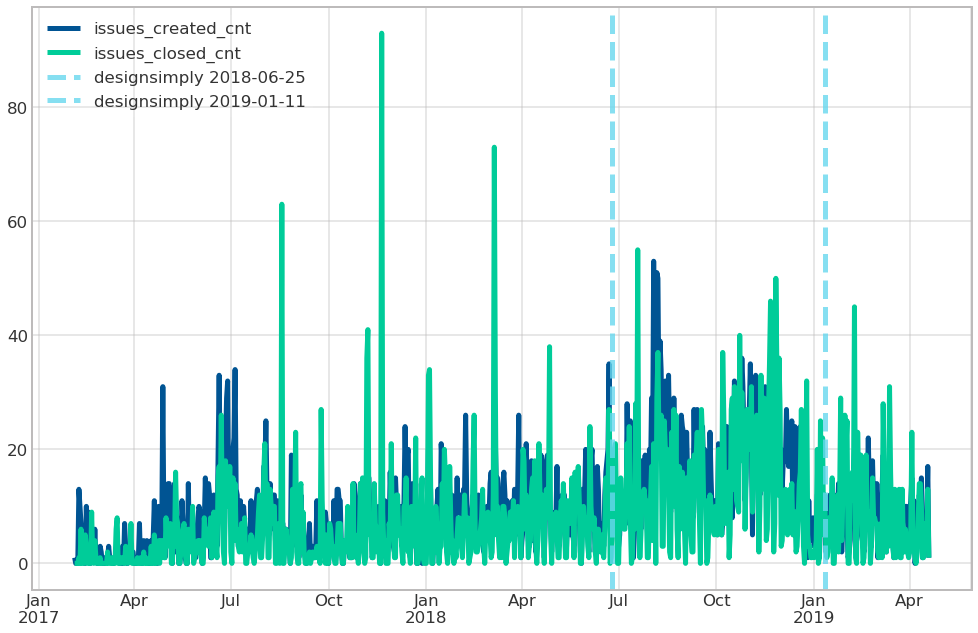

In [71]:
plt.figure(figsize=(15, 10))
df_day_issues['issues_created_cnt'].plot(
    color=crayons.dark_blue,
)
df_day_issues['issues_closed_cnt'].plot(
    color=crayons.caribbean_green,
)
#df_day_issues['issues_updated_cnt'].plot()
plot_designsimply_start_date()
plt.legend()


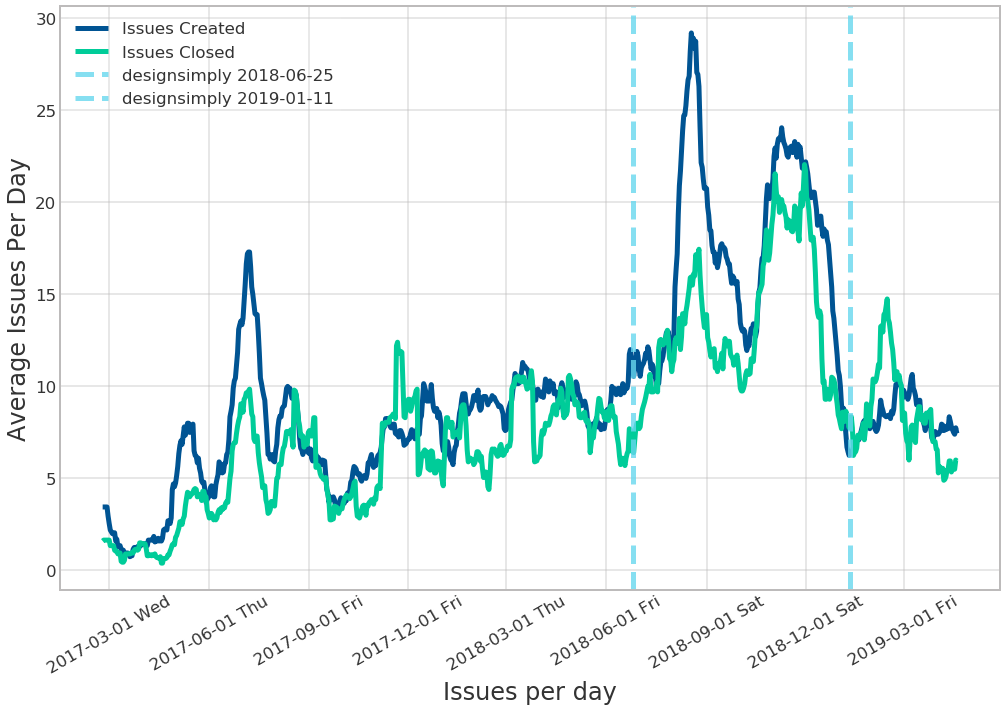

In [72]:
plt.plot(
    df_day_issues.index,
    df_day_issues['issues_created_cnt'].rolling(20).mean(),
    label='Issues Created',
    color=crayons.dark_blue,    
)

plt.plot(
    df_day_issues.index,
    df_day_issues['issues_closed_cnt'].rolling(20).mean(),
    label='Issues Closed',
    color=crayons.caribbean_green,    
)

plt.xlabel('Issues per day')

#plt.xlim(pd.Timestamp('2018-07-25'), pd.Timestamp('2018-08-15'))

plt.gca().xaxis.set_major_formatter(
    plt.matplotlib.dates.DateFormatter('%Y-%m-%d %a')
)
plt.ylabel('Average Issues Per Day')
#plt.axvline(pd.Timestamp('2018-08-02'))
plot_designsimply_start_date()
plt.xticks(rotation=30)
plt.legend()
#plot_attrs_time()

## Issues Closed All Time

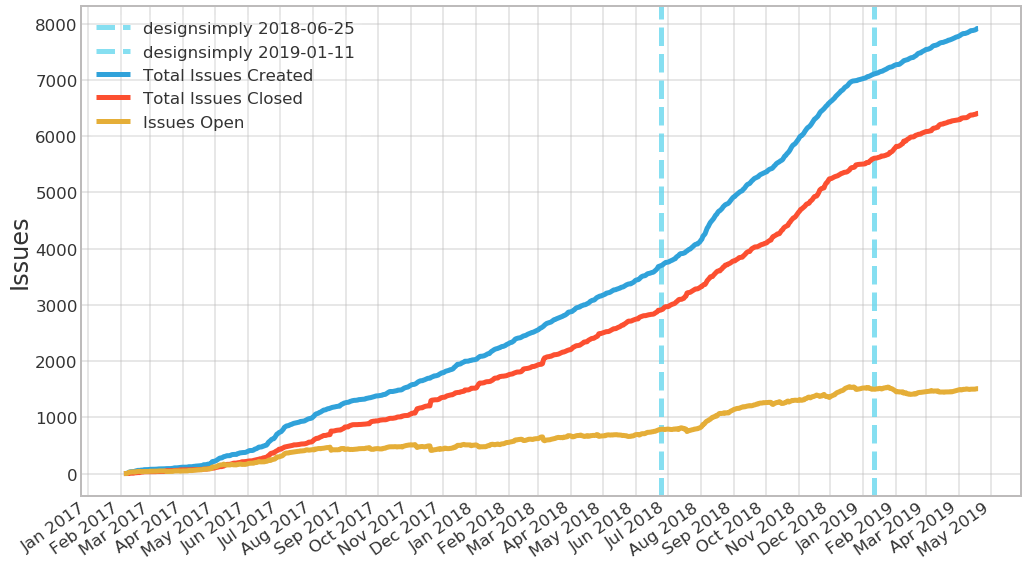

In [73]:
plt.figure(figsize=(15, 10))

plot_designsimply_start_date()

df_day_issues['issues_created_cnt_cuml'].plot(
    #color=crayons.dark_blue,
    label='Total Issues Created',
)
df_day_issues['issues_closed_cnt_cuml'].plot(
    #color=crayons.b_pink,
    label='Total Issues Closed',
)
df_day_issues['issues_open'].plot(
    label='Issues Open',
    #color=crayons.dark_grey,
)


plt.legend(loc=2)
plt.ylabel('Issues')
plot_attrs_time()

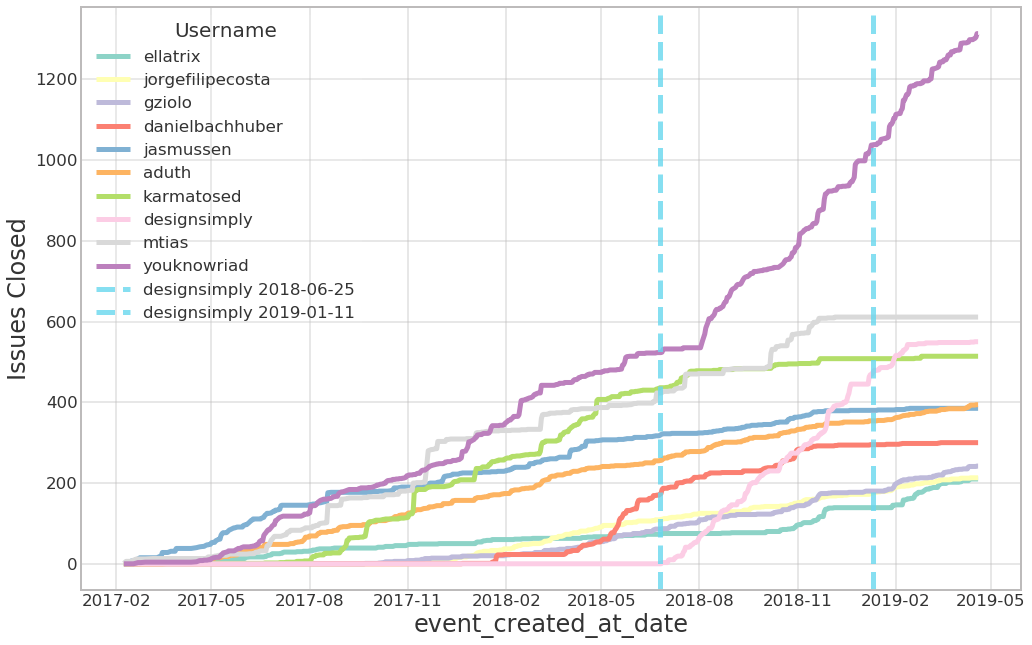

In [74]:
top_actors = df_actor_issues_closed.sum().sort_values()[-10:]

(
    df_actor_issues_closed
    .loc[:, top_actors.index]
    .fillna(0)
    .cumsum(axis=0)
    .plot(
        color=sns.color_palette('Set3', len(top_actors)),
        legend=False,
    )
)
plot_designsimply_start_date()
plt.legend(loc=2, title='Username')
plt.ylabel('Issues Closed')
plt.show()

In [75]:
print('\n\n\nLeaderboard for Closed Issues All Time ')
(
    df_events
    .query('event == "closed"')
    .groupby('event_actor_username')
    ['event_issue_ext_id']
    .nunique()
    .sort_values(ascending=False)
    .head(10)
    .to_frame('issues_closed')

)




Leaderboard for Closed Issues All Time 


,issues_closed
event_actor_username,
youknowriad,1305
mtias,607
designsimply,545
karmatosed,510
aduth,387
jasmussen,382
danielbachhuber,296
gziolo,237
jorgefilipecosta,212


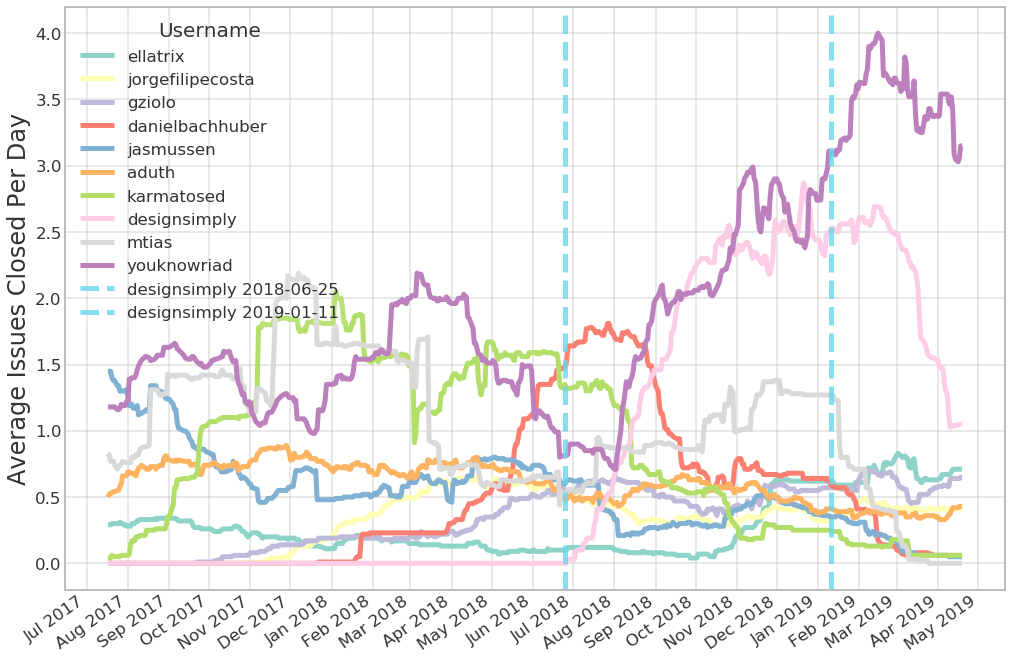

In [76]:

top_actors = df_actor_issues_closed.sum().sort_values()[-10:]

values =(
    df_actor_issues_closed
    .fillna(0)
    .loc[:, top_actors.index]
    .rolling(100)
    .mean()
    .plot(
        color=sns.color_palette('Set3', len(top_actors)),
        legend=False,
    )
)
plot_designsimply_start_date()
plt.legend(loc=2, title='Username', fancybox=True)
plt.ylabel('Average Issues Closed Per Day')
plot_attrs_time()

In [77]:
df_actor_all_time = pd.DataFrame()
df_actor_all_time['avg_closed_per_day'] = df_actor_issues_closed.mean()
df_actor_all_time['p75_closed_per_day'] = df_actor_issues_closed.quantile(0.75)
df_actor_all_time['std_closed_per_day'] = df_actor_issues_closed.std()
df_actor_all_time['contribution_days'] = df_actor_issues_closed.count()
(
    df_actor_all_time
    .query('contribution_days > 50')
    .sort_values('avg_closed_per_day', ascending=False)
    .head(10)
)

,avg_closed_per_day,p75_closed_per_day,std_closed_per_day,contribution_days
event_actor_username,,,,
mtias,4.395683,4.0,8.947203,139
designsimply,3.928571,5.0,3.603841,140
youknowriad,3.873156,4.0,4.648454,339
karmatosed,3.544828,3.0,5.626055,145
danielbachhuber,2.857143,4.0,2.850198,105
jasmussen,2.212644,2.0,2.536590,174
tofumatt,2.027027,2.0,1.621541,74
ellatrix,1.826087,2.0,1.826995,115
gziolo,1.766423,2.0,1.238255,137


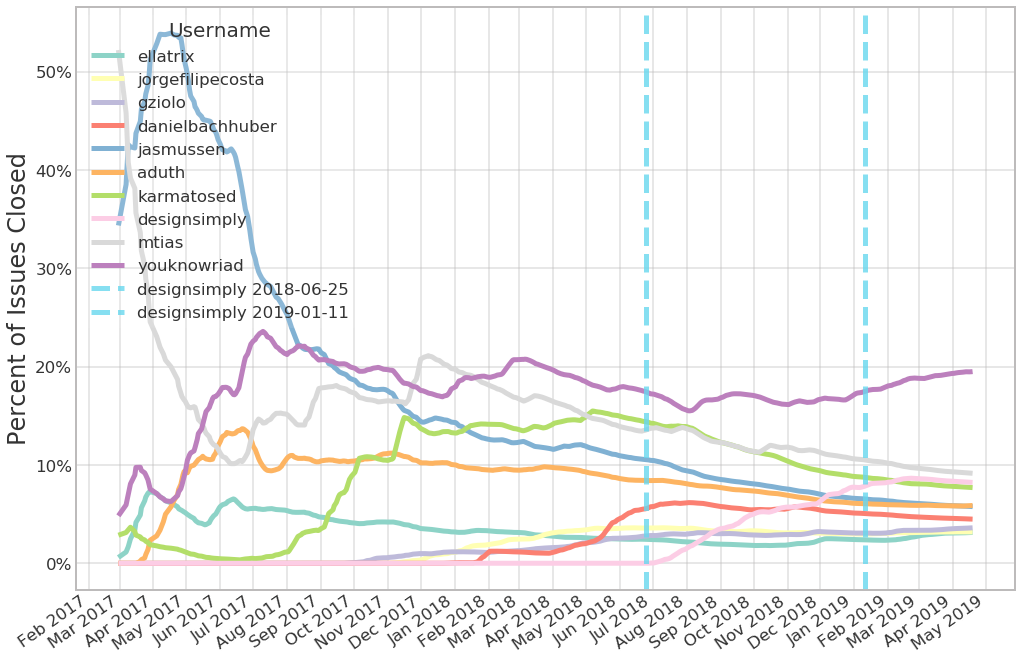

In [78]:

top_actors = df_actor_issues_closed.sum().sort_values()[-10:]

values =(
    df_actor_issues_closed
    .fillna(0)
    .cumsum(axis=0)
)
df_actor_issues_closed_pct = (
    (values.T / values.sum(axis=1)).T
)
(
    df_actor_issues_closed_pct
    .loc[:, top_actors.index]
    .rolling(10)
    .mean()
    .plot(
        color=sns.color_palette('Set3', len(top_actors)),
        legend=False,
    )
)
plot_designsimply_start_date()
plt.legend(loc=2, title='Username', fancybox=True)
plt.ylabel('Percent of Issues Closed')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:.0%}'))
plt.xlabel('')
plot_attrs_time()

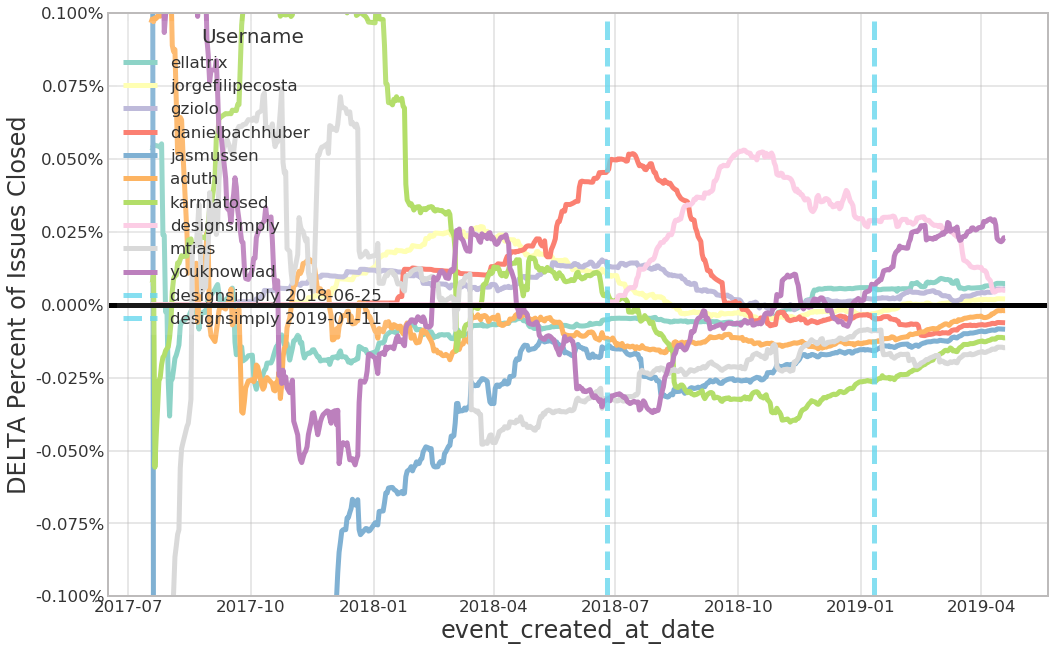

In [79]:
(
    df_actor_issues_closed_pct
    .loc[:,top_actors.index]
    .diff() 
    .rolling(100)
    .mean()    
    .plot(
        color=sns.color_palette('Set3', len(top_actors)),
        legend=False,
    )
)
plot_designsimply_start_date()

plt.axhline(0, color='k')
plt.legend(loc=2, title='Username')
plt.ylim(-0.001, 0.001)
plt.ylabel('DELTA Percent of Issues Closed')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:.3%}'))


## Issues Closed designsimply

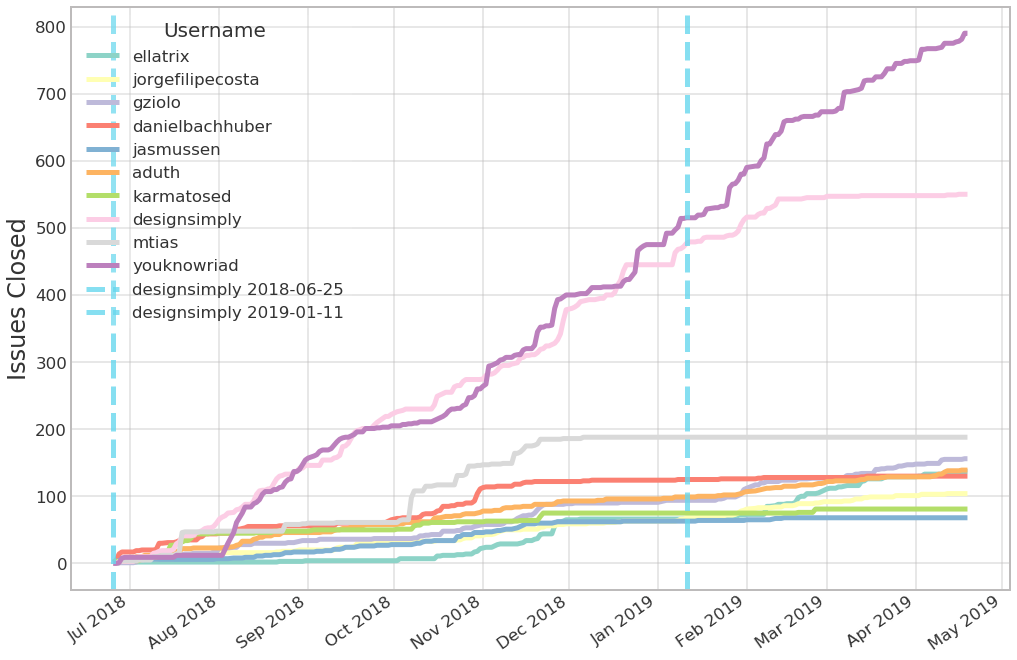

In [80]:
top_actors = df_actor_issues_closed.sum().sort_values()[-10:]

(
    df_actor_issues_closed
    .loc[DESIGNSIMPLY_START_DATE:, top_actors.index]
    .fillna(0)
    .cumsum(axis=0)
    .plot(
        color=sns.color_palette('Set3', len(top_actors)),
        legend=False,
    )
)
plot_designsimply_start_date()


plt.legend(loc=2, title='Username')
plt.ylabel('Issues Closed')
plot_attrs_time()

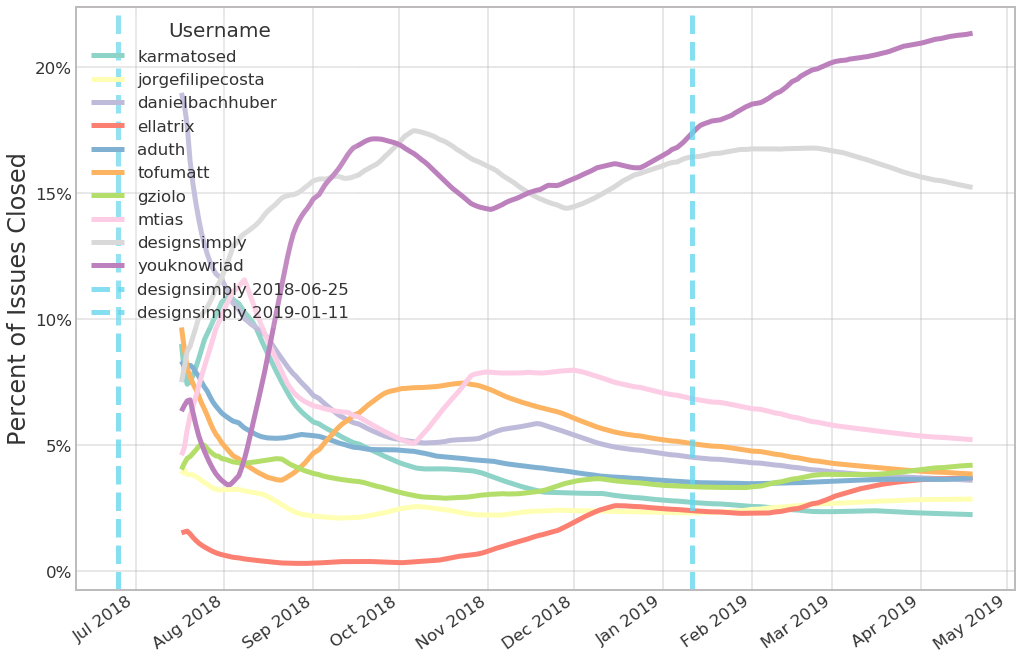

In [81]:
top_actors = df_actor_issues_closed.loc[DESIGNSIMPLY_START_DATE:,].sum().sort_values()[-10:]

values =(
    df_actor_issues_closed
    .loc[DESIGNSIMPLY_START_DATE:,]
    .fillna(0)
    .cumsum(axis=0)
)
df_actor_issues_closed_pct = (
    (values.T / values.sum(axis=1)).T
)
(
    df_actor_issues_closed_pct
    .loc[:, top_actors.index]
    .rolling(20)
    .mean()
    .plot(
        color=sns.color_palette('Set3', len(top_actors)),
        legend=False,
    )
)
plot_designsimply_start_date()
plt.legend(loc=2, title='Username', fancybox=True)
plt.ylabel('Percent of Issues Closed')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:.0%}'))
plot_attrs_time()

## Issues Labeled

In [82]:
df_actor_issues_labeled = (
    df_events
    .query('event == "labeled"')
    .groupby([
        'event_created_at_date',
        'event_actor_username',
    ])
    ['event_issue_ext_id']
    .nunique()
    .unstack()   
)

In [83]:
df_issues_labeled_cnt = (
    df_events
    .query('event == "labeled"')
    .groupby([
        'event_created_at_date',
    ])
    ['event_issue_ext_id']
    .nunique()
)

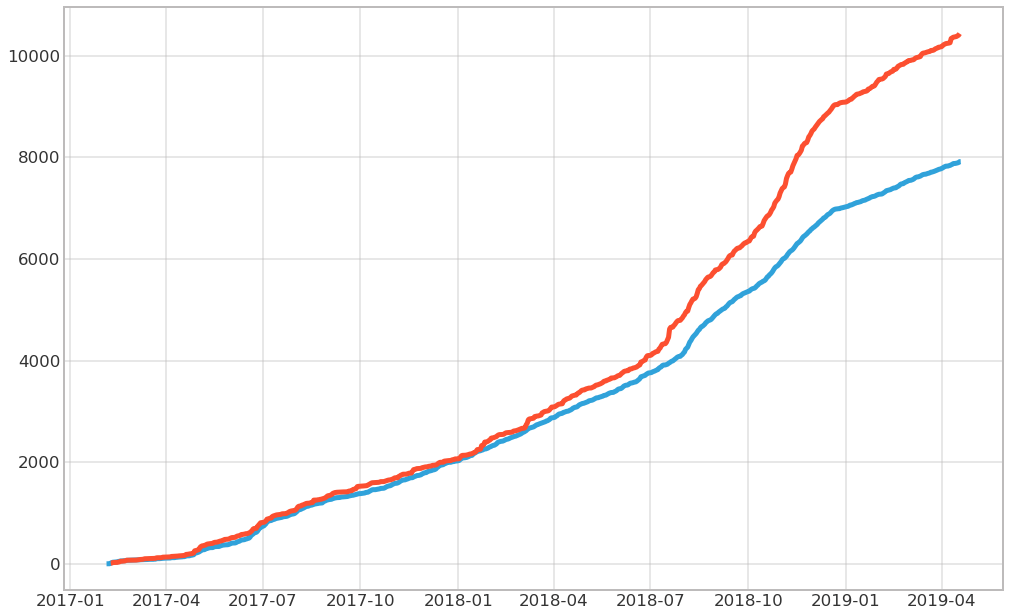

In [84]:
plt.figure()
plt.plot(
    df_day_issues.index,
    df_day_issues['issues_created_cnt_cuml'].values,
)

plt.plot(
    df_issues_labeled_cnt.index.astype(pd.Timestamp),
    df_issues_labeled_cnt.cumsum().values,
)


In [85]:
df = df_day_issues.describe().T
df['sum'] = df_day_issues.sum().T
df

,count,mean,std,min,25%,50%,75%,max,sum
issues_created_cnt,805.0,9.834783,8.119216,0.0,4.00,8.0,14.00,53.0,7917.0
issues_closed_cnt,805.0,7.959006,9.474478,0.0,1.00,5.0,11.00,93.0,6407.0
issues_updated_cnt,805.0,9.834783,11.949054,0.0,2.00,6.0,14.00,81.0,7917.0
issues_created_cnt_cuml,805.0,3256.250932,2507.554642,1.0,1195.00,2696.0,5353.00,7917.0,2621282.0
issues_closed_cnt_cuml,805.0,2520.329193,2035.051926,0.0,772.00,2087.0,4093.00,6407.0,2028865.0
issues_open,805.0,735.921739,479.114869,1.0,430.00,626.0,1249.00,1546.0,592417.0
issues_unupdated,805.0,681.672050,407.057673,0.0,419.00,618.0,1018.00,1393.0,548746.0
issues_labeled_by_designsimply,175.0,13.434286,12.629785,1.0,3.00,11.0,20.50,84.0,2351.0
issues_effected_by_designsimply,202.0,14.683168,13.969000,1.0,3.00,12.0,23.75,93.0,2966.0
events_by_designsimply,202.0,32.836634,31.538463,1.0,6.25,24.5,51.75,181.0,6633.0


In [86]:
sub = (
    df_events
    [df_events['event_created_at'] > pd.Timestamp('2018-10-01T00:00:00Z')]
    .query('event == "labeled"')
)        
total_labeled_issues = sub['event_issue_ext_id'].nunique()
df = (
    sub
    .groupby(['event_actor_username'])
    ['event_issue_ext_id']
    .nunique()
    .sort_values(ascending=False)
    .to_frame('issues_labeled_cnt')
)
df['issues_labeled_percent'] = df['issues_labeled_cnt'] / total_labeled_issues
df[:10]

,issues_labeled_cnt,issues_labeled_percent
event_actor_username,,
designsimply,1015,0.339806
swissspidy,525,0.175762
mtias,314,0.105122
youknowriad,274,0.091731
Soean,220,0.073652
ellatrix,155,0.051892
afercia,151,0.050552
gziolo,144,0.048209
danielbachhuber,121,0.040509


## Issues Labeled designsimply

Text(0.5,0,'')

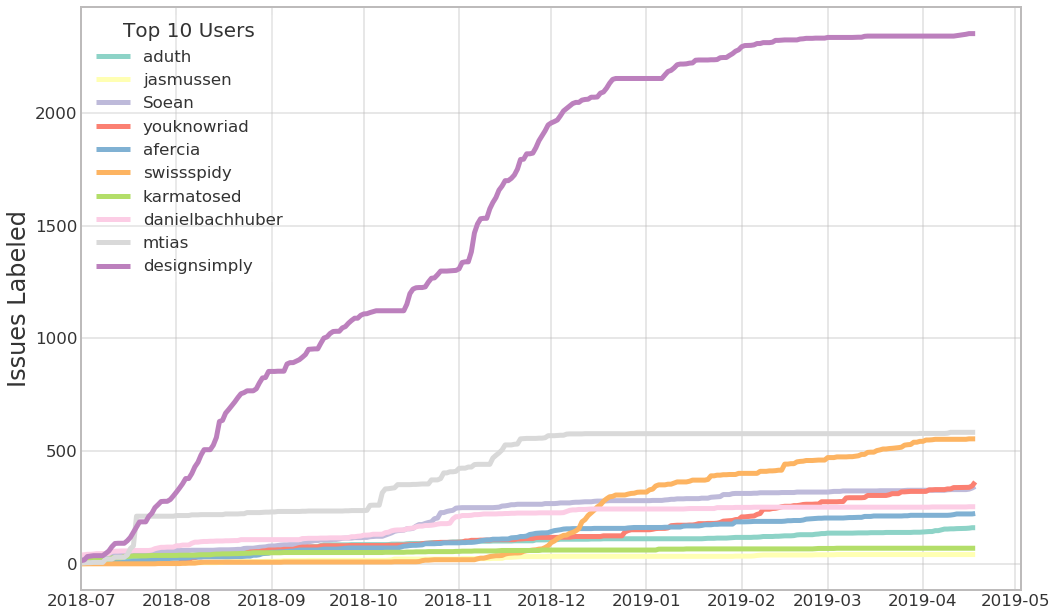

In [87]:
top_actors = df_actor_issues_labeled.sum().sort_values()[-10:]
(
    df_actor_issues_labeled
    .loc[DESIGNSIMPLY_START_DATE:
        , 
        top_actors.index]
    .fillna(0)
    .cumsum(axis=0)
    .plot(
        color=sns.color_palette('Set3', len(top_actors)),
        legend=False,
    )
)
plt.legend(title='Top 10 Users')
plt.ylabel("Issues Labeled")
plt.xlim(pd.Timestamp('2018-07-01'), None)
plt.xlabel('')

## Events per day designsimply

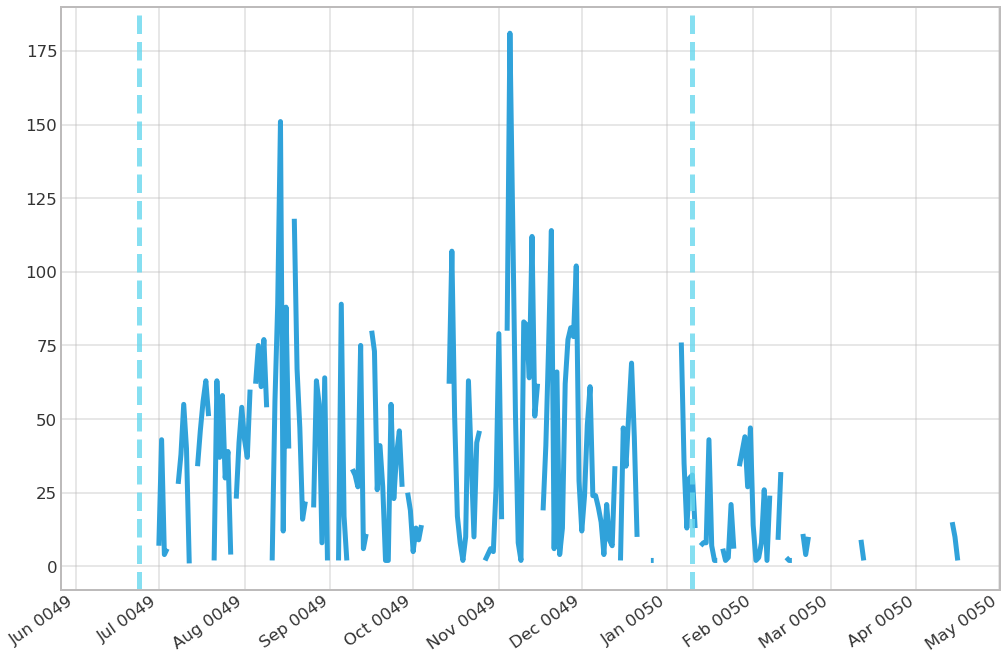

In [88]:
plt.figure(figsize=(15, 10))

df_day_issues['events_by_designsimply'].plot()
plot_designsimply_start_date()
plot_attrs_time()

Text(0,0.5,'Issue Actions by designsimply')

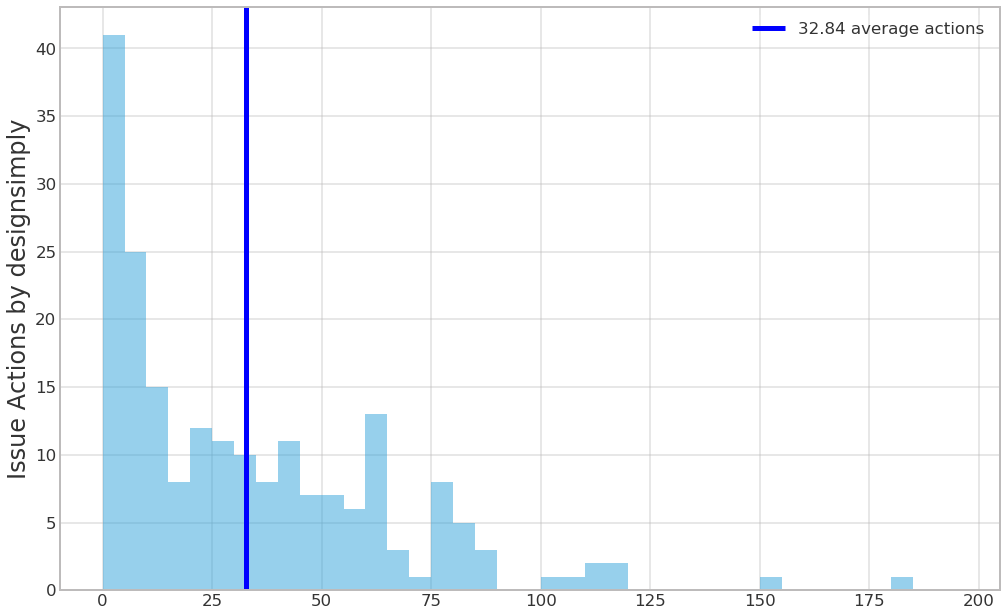

In [89]:
d1 = df_day_issues['events_by_designsimply']
d1.hist(bins=np.arange(0,200, 5), alpha=0.5,)
plt.axvline(
    d1.mean(),
    label='{:.2f} average actions'.format(d1.mean()),
    color='b',
)
plt.legend(loc=1)
plt.ylabel('Issue Actions by designsimply')

## Events by user

In [90]:
df_actor_issues_touched = (
    df_events
    .groupby([
        'event_created_at_date',
        'event_actor_username',
    ])
    ['event_issue_ext_id']
    .nunique()
    .unstack()   
)

Text(0,0.5,'Issues Acted Upon')

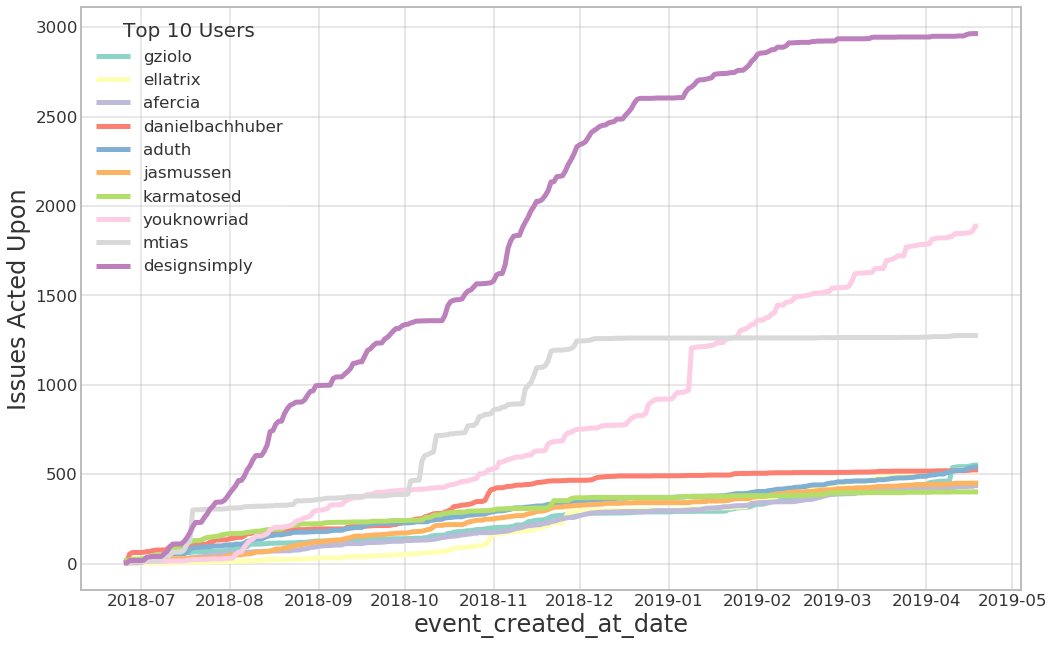

In [91]:
top_actors = df_actor_issues_touched.sum().sort_values()[-10:]
(
    df_actor_issues_touched
    .loc[DESIGNSIMPLY_START_DATE:, top_actors.index]
    .fillna(0)
    .cumsum(axis=0)
    .plot(
        color=sns.color_palette('Set3', len(top_actors)),
        legend=False,        
    )
)
plt.legend(title='Top 10 Users')
plt.ylabel("Issues Acted Upon")


## Bug Labels

In [92]:
df = (
    df_events
    .groupby('event_label')
    ['event_issue_ext_id']
    .nunique()
    .sort_values()
    .to_frame('issue_cnt')
)
df['issue_pct'] = df['issue_cnt'] / df['issue_cnt'].sum()
df

,issue_cnt,issue_pct
event_label,,
wontfix,1,0.000058
[Block] Spacer,1,0.000058
[Block] Tag Cloud,1,0.000058
[Package] Autop,1,0.000058
[Package] Babel plugin import JSX pragma,1,0.000058
[Package] Babel preset,1,0.000058
Good First Review,1,0.000058
[Package] DOM,1,0.000058
[Package] Deprecated,1,0.000058


In [93]:
bug_issues = (
    df_events
    #.query('label_name == "[Type] Bug"')
    .query('event_label == "[Type] Help Request"')
    .groupby('event_issue_ext_id')
    ['event_created_at']
    .min()
    .to_frame('bug_label_created_at')
)

In [94]:
df_issues['bug_label_created_date'] = (
    df_issues[['issue_ext_id']]
    .merge(
        bug_issues,
        how='left',
        right_index=True,
        left_on='issue_ext_id',        
    )
    ['bug_label_created_at']
    .dt
    .date
)

In [95]:
df_issues['is_labeled_bug'] = ~df_issues['bug_label_created_date'].isnull()

In [96]:
df_day_bug_issues = calc_day_issues(df_issues.query('is_labeled_bug'))

In [97]:
df_day_bug_issues['issues_labeled_bug_cnt'] = (
    df_issues
    .groupby('bug_label_created_date')
    .size()
    
)

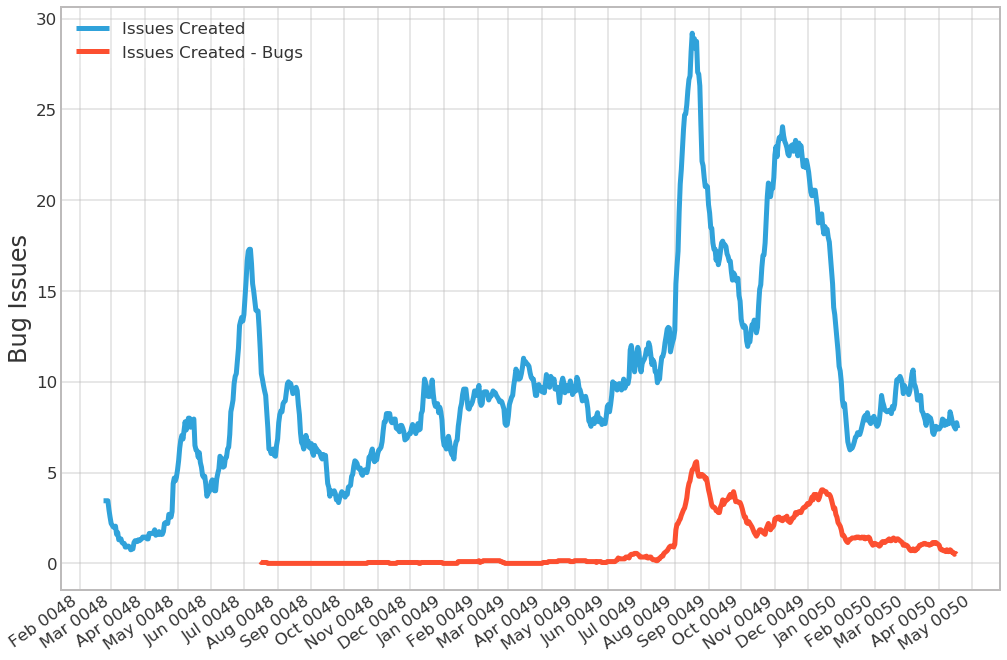

In [98]:
df_day_issues['issues_created_cnt'].rolling(20).mean().plot(
    label="Issues Created"
)
df_day_bug_issues['issues_created_cnt'].rolling(20).mean().plot(
    label="Issues Created - Bugs"
)
plt.legend()
plt.ylabel('Bug Issues')
plot_attrs_time()

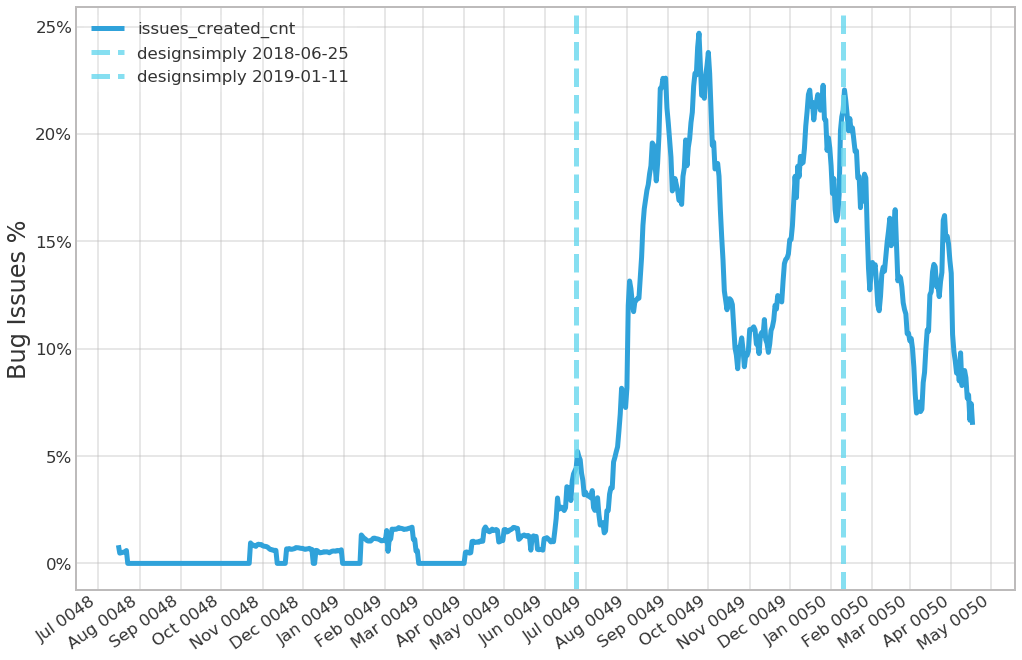

In [99]:
(
    df_day_bug_issues['issues_created_cnt'].rolling(20).mean() / df_day_issues['issues_created_cnt'].rolling(20).mean()
).plot()

plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:.0%}'))
plot_designsimply_start_date()
plt.legend()
plt.ylabel('Bug Issues %')
plot_attrs_time()

In [100]:
df_day_bug_issues['issues_open_cnt'] = (
    df_day_bug_issues['issues_created_cnt'].cumsum() - df_day_bug_issues['issues_closed_cnt'].cumsum()
)

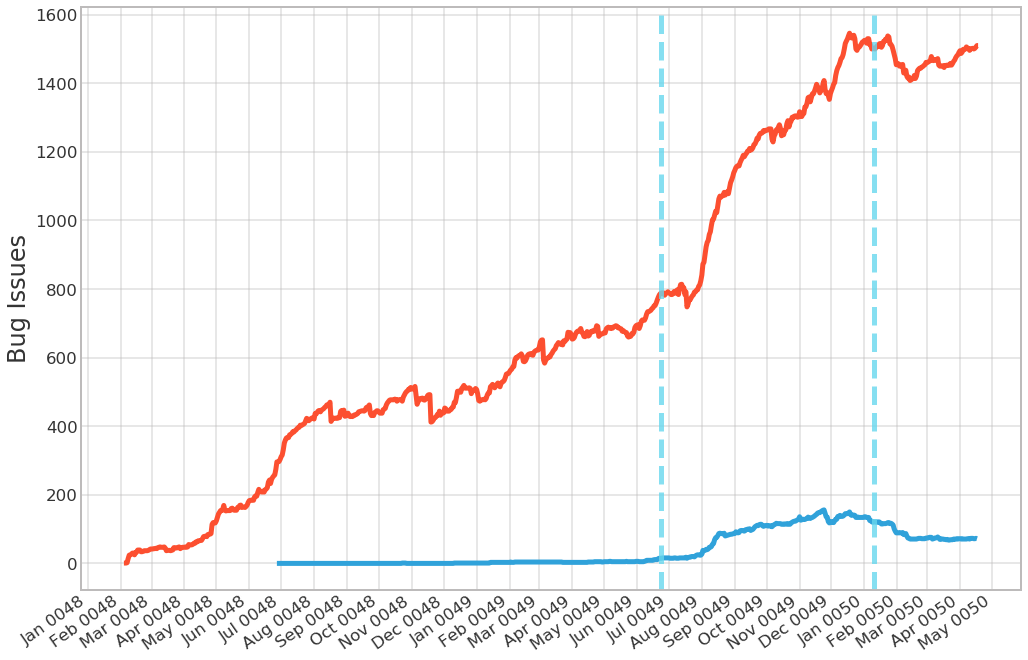

In [101]:
df_day_bug_issues['issues_open_cnt'].plot()
(df_day_issues['issues_created_cnt'].cumsum() - df_day_issues['issues_closed_cnt'].cumsum()).plot()

plt.ylabel('Bug Issues')
plot_designsimply_start_date()
plot_attrs_time()

## Help Requests

In [102]:
help_issues = (
    df_events
    #.query('label_name == "[Type] Bug"')
    .query('event_label == "[Type] Help Request"')
    .groupby('event_issue_ext_id')
    ['event_created_at']
    .min()
    .to_frame('help_label_created_at')
)

In [103]:
df_issues['help_label_created_date'] = (
    df_issues[['issue_ext_id']]
    .merge(
        help_issues,
        how='left',
        right_index=True,
        left_on='issue_ext_id',        
    )
    ['help_label_created_at']
    .dt
    .date

)

In [104]:
df_day_issues['issues_labeled_help_request_cnt'] = (
    df_issues
    .groupby('help_label_created_date')
    .size()
    
)

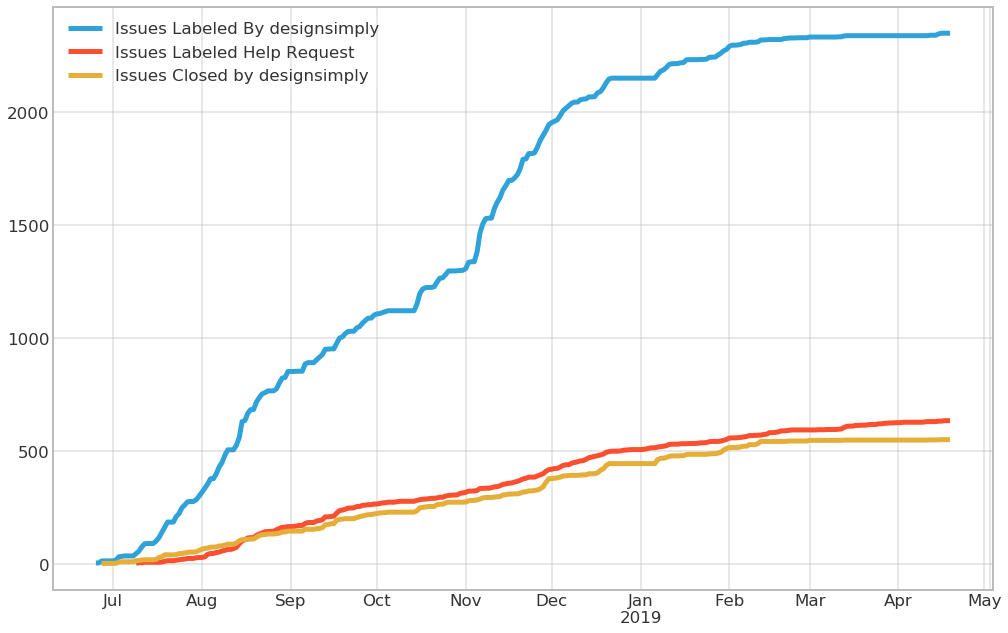

In [105]:
df_day_issues['issues_labeled_by_designsimply'].cumsum().fillna(method='ffill').plot(
    ls='-',
    label='Issues Labeled By designsimply',
)
df_day_issues['issues_labeled_help_request_cnt'].cumsum().fillna(method='ffill').plot(

    ls='-',
        label='Issues Labeled Help Request',

)
df_day_issues['issues_closed_by_designsimply'].cumsum().fillna(method='ffill').plot(
    ls='-',
    label='Issues Closed by designsimply',
)
plt.legend()
